In [29]:

# 🔧 2. Import model from local src folder
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path  # ✅ Required for Path()
from datetime import datetime

src_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# ✅ Import model now works
from src.models.model import PalmerasModel


 
 self.blackboard["charging_stations_positions"] 
 
{(8, 11): 0}
 
 

--- choose_best_target DEBUG ---
[Input] Current drone position: (8, 11)
[Input] Targets (raw): []
[Info] No targets provided. Returning None.
[WARNING] Drone 146 attempted invalid move to (8, 12)

--- choose_best_target DEBUG ---
[Input] Current drone position: (8, 11)
[Input] Targets (raw): []
[Info] No targets provided. Returning None.

--- choose_best_target DEBUG ---
[Input] Current drone position: (9, 11)
[Input] Targets (raw): []
[Info] No targets provided. Returning None.

--- choose_best_target DEBUG ---
[Input] Current drone position: (10, 11)
[Input] Targets (raw): []
[Info] No targets provided. Returning None.
[AUTO-INFECTED] Palm at (4, 6) became infected randomly.

--- choose_best_target DEBUG ---
[Input] Current drone position: (11, 11)
[Input] Targets (raw): []
[Info] No targets provided. Returning None.
[WARNING] Drone 146 attempted invalid move to (12, 11)

--- choose_best_target DEBUG ---
[Input] 

/var/folders/yv/1tl1x8xx7_51dbj7560khxhm0000gn/T/ipykernel_99696/1543318539.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jorge.mayorga/Documents/GitHub/multiagent-course-project-sim/v2/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


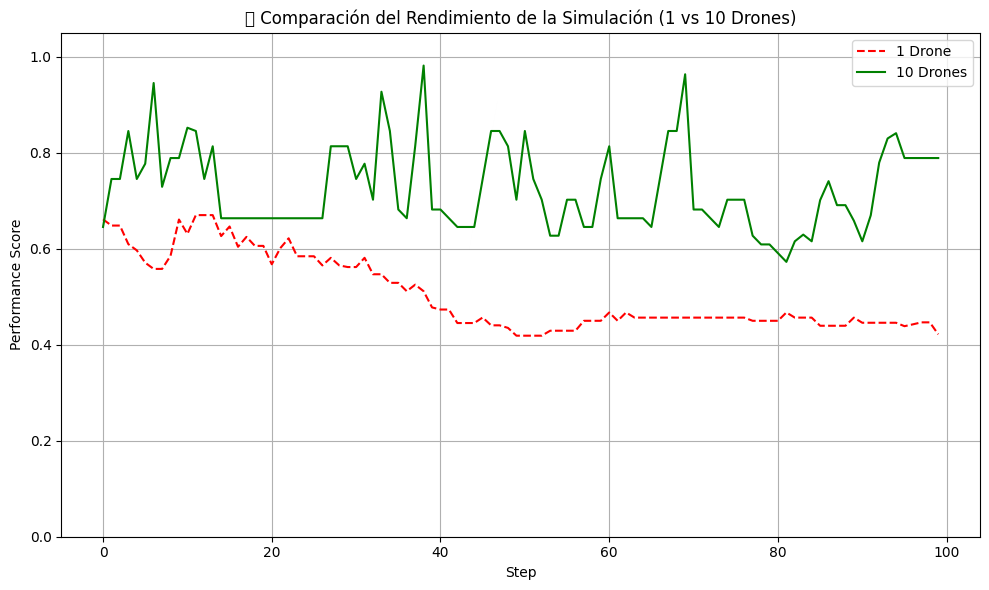

📌 Puntaje Final:
• 1 Drone:   0.4218
• 10 Drones: 0.7891


In [30]:

# 🛠 3. Simulation runner function
def run_simulation(params: dict, tag: str = None):
    model = PalmerasModel(
        width=params["width"],
        height=params["height"],
        densidad=params["densidad"],
        n_drones=params["n_drones"],
        tasa_propagacion=params["tasa_propagacion"],
        tasa_cura=params["tasa_cura"]
    )

    for _ in range(params["max_steps"]):
        model.step()

    model_df = model.datacollector.get_model_vars_dataframe()
    agents_df = model.datacollector.get_agent_vars_dataframe()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    tag = tag or f"{params['n_drones']}_drones"
    output_dir = Path(f"../results/simulation_{tag}_{timestamp}")
    output_dir.mkdir(parents=True, exist_ok=True)

    model_df.to_csv(output_dir / "model_data.csv")
    agents_df.to_csv(output_dir / "agents_data.csv")
    with open(output_dir / "params.json", "w") as f:
        json.dump(params, f, indent=4)

    print(f"✅ Simulation saved to {output_dir}")
    return model_df, agents_df, output_dir


# 🧠 4. Performance Score calculation
def safe_div(n, d):
    return n / d if d > 0 else 0

def compute_score(row):
    palmas_totales = row["PalmasTotales"]
    infectadas = row["PalmasInfectadas"]
    cured_rate = safe_div(row["PalmasSanas"], palmas_totales)
    burned_rate = safe_div(row["PalmasQuemadas"], palmas_totales)
    detection_rate = safe_div(row["PalmasDetectadas"], infectadas)
    return 0.4 * cured_rate + 0.3 * (1 - burned_rate) + 0.3 * detection_rate


# 🚀 5. Define scenarios and run
base_params = {
    "width": 12,
    "height": 12,
    "densidad": 0.2,
    "tasa_propagacion": 0.1,
    "tasa_cura": 0.8,
    "max_steps": 100
}

# Scenario A - 1 Drone
params_1 = base_params.copy()
params_1["n_drones"] = 1
df_1, _, _ = run_simulation(params_1, tag="1drone")

# Scenario B - 10 Drones
params_10 = base_params.copy()
params_10["n_drones"] = 10
df_10, _, _ = run_simulation(params_10, tag="10drones")


# 📊 6. Add performance score column
df_1["PerformanceScore"] = df_1.apply(compute_score, axis=1)
df_10["PerformanceScore"] = df_10.apply(compute_score, axis=1)


# 📈 7. Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(df_1.index, df_1["PerformanceScore"], label="1 Drone", linestyle="--", color="red")
plt.plot(df_10.index, df_10["PerformanceScore"], label="10 Drones", linestyle="-", color="green")
plt.xlabel("Step")
plt.ylabel("Performance Score")
plt.title("📊 Comparación del Rendimiento de la Simulación (1 vs 10 Drones)")
plt.grid(True)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 8. Final results
print("📌 Puntaje Final:")
print(f"• 1 Drone:   {df_1['PerformanceScore'].iloc[-1]:.4f}")
print(f"• 10 Drones: {df_10['PerformanceScore'].iloc[-1]:.4f}")
